<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA2024/blob/main/Python/CP5_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Element Method in 1D

1. Linear ($k=1$) Finite Element Method solver for the 1D Poisson problem:

$-u''=f \quad \in \Omega=(a,b)^2$

$u(a)=0=u(b)$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

FEM system assembly with trapezoidal rule for rhs

In [3]:
def FEM1_1D_TRAP(omega, N, rhs):
  # 1D FEM with k=1 system matrix and rhs for
  # diffusion problem with homogeneous Dirichlet bc
  # trapezoidal rule

  # grid is defined here as uniform
  h = (omega[1] - omega[0]) / N
  x = np.linspace(omega[0], omega[1], N + 1)

  # initialise system
  A = sp.lil_matrix((N + 1, N + 1))
  F = np.zeros(N + 1)

  for i in range(N):

    # local contributions
    A_ele = np.matrix([[1/h, -1/h],[-1/h, 1/h]])
    F_ele = 0.5 * h * rhs(x[i:i+2])
    
    # Assembly local-to-global
    A[i:i+2, i:i+2] += A_ele
    F[i:i+2] += F_ele

  # Apply boundary conditions
  A[0, 0] = 1/h; A[0, 1] = 0; F[0] = 0
  A[N, N] = 1/h; A[N, N-1] = 0; F[N] = 0

  # return system matrix and rhs vector
  return A, F

Define FEM problem and solve

8.225076221068939e-05


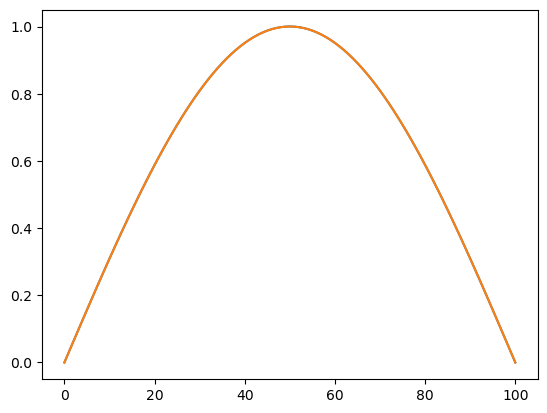

In [4]:
# problem data
omega = [0, np.pi]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

N = 100 # number of subdivisions

A, F = FEM1_1D_TRAP(omega, N, rhs)

# solve
A = A.tocsr()
Uh = sp.linalg.spsolve(A,F)

# evaluate exact solution at grid nodes
x = np.linspace(omega[0], omega[1], N + 1)
U = exact(x)

plt.plot(Uh)
plt.plot(U)

print(max(abs(U - Uh)))

2. Repeat exercise but for the non-homogeneous Dirichlet conditions, so:

$-u''=f \quad \in \Omega=(a,b)^2$

$u(a)=g(a)$ and $u(b)=g(b)$

for $g$ a given function.

Also:
- allow for nonuniform grid
- use reference element to assemble
- to compute the rhs, use arbitrary order Gauss integration

In [6]:
# Gauss quadrature formula on [0,1]
def quadrature(n_quadrature_points):

  # exploit numpy Gauss quadrature. This is defined in [-1,1]
  q, w = np.polynomial.legendre.leggauss(n_quadrature_points)
  
  # transform points and weights to [0, 1]
  return (q + 1) / 2, w / 2

Function defining the mesh

In [7]:
def mesh(omega, N):
  return np.linspace(omega[0], omega[1], N + 1)

Define reference element transformation of coordinates

In [8]:
# Transformation of coordinates functions:
# reference element -> current element
# [0,1] -> [q[i], q[i+1]]

def mapping(q, i):
    # check index is within range
    assert i < len(q) - 1
    assert i >= 0
    return lambda x: q[i] + (q[i+1] - q[i]) * x

# returns the length of the i-th element, which is used to scale the integrals properly
# (the Jacobian of a linear mapping is simply the length of the element)
def mapping_J(q, i):
    assert i < len(q) - 1
    assert i >= 0
    return q[i+1] - q[i]

# linear lagrange basis on reference element
def basis1(i):
    assert i < 2
    assert i >= 0
    if i == 0:
      phi = lambda x: 1 - x
    else:
      phi = lambda x: x
    return phi

# derivatives of linear lagrange basis on reference element
def basis1_derivative(i):
    assert i < 2
    assert i >= 0
    if i == 0:
      dphi = lambda x: -np.ones(len(x))
    else:
      dphi = lambda x: np.ones(len(x))
    return dphi

FEM system assembly with Gauss integration

In [9]:
def FEM1_1D_GAUSS(omega, N, n_qpoints, rhs, mesh): # added mesh as argument
  # 1D FEM with k=1 system matrix and rhs
  # not accounting for boundary conditions

  vertices = mesh(omega, N) # grid

  q, w = quadrature(n_qpoints) # quadrature formula on reference element

  # evaluation of the two local linear Lagrange basis
  phi = np.array([basis1(i)(q) for i in range(2)]).T
  dphi = np.array([basis1_derivative(i)(q) for i in range(2)]).T

  # initialise system
  A = sp.lil_matrix((N+1, N+1))
  F = np.zeros(N+1)

  # iterate over each element of the mesh
  for i in range(N):

    JxW = mapping_J(vertices, i) * w # compute weights for the quadrature rule scaled by the Jacobian

    # np.einsum: Einstein summation convention
    # compute the local stiffness matrix by summing the product of the derivatives of the basis functions 
    # and the quadrature weights over the quadrature points, then normalize by the element size (squared Jacobian)
    A_ele = np.einsum('qi,qj,q', dphi, dphi, JxW) / mapping_J(vertices, i)**2

    # compute the local load vector using the basis functions, 
    # the right-hand side evaluated at the mapped quadrature points, and the scaled quadrature weight
    F_ele = np.einsum('qi,q,q', phi, rhs(mapping(vertices,i)(q)), JxW)

    # add the local stiffness matrix and local load vector to the global ones
    A[i:i+2, i:i+2] += A_ele
    F[i:i+2] += F_ele

  return A, F

np.einsum('qi,qj,q', dphi, dphi, JxW)

-   dphi: 2D array where each row corresponds to the values of a basis function's derivative at the quadrature points

-   JxW: 1D array of quadrature weights scaled by the Jacobian, which represents the integration weights for the current element

-   qi: specifies that the first dphi array should have its first axis (rows) labeled as q and the second axis (columns) labeled as i

-   qj: specifies that the second dphi array should have its first axis labeled as q and the second axis labeled as j

-   q: specifies that the JxW array should have its axis labeled as q

The subscripts 'qi,qj,q' tell np.einsum to:

-   multiply the elements of the first dphi with the elements of the second dphi and JxW where the first axis (corresponding to q, the quadrature points) is the same.

-   sum over the first axis (q), which corresponds to summing over the quadrature points.

In essence, this computes:
$Aele[i,j]=∑_q(dphi[q,i]⋅dphi[q,j]⋅JxW[q])$

This summation is done for all combinations of i and j, resulting in a local stiffness matrix

Function implementing the boundary (nonhomogeneous) Dirichlet conditions. (Similar to FD code, but boundary condition given by function $g$!)

In [35]:
def apply_boundary_conditions(omega, N, A, F, g):
    A[0,0] = 1; A[0,1] = 0; F[0] = g(omega[0])
    A[N,N] = 1; A[N,N-1] = 0; F[N] = g(omega[1])

Define FEM problem and solve

4.1126903210453314e-05


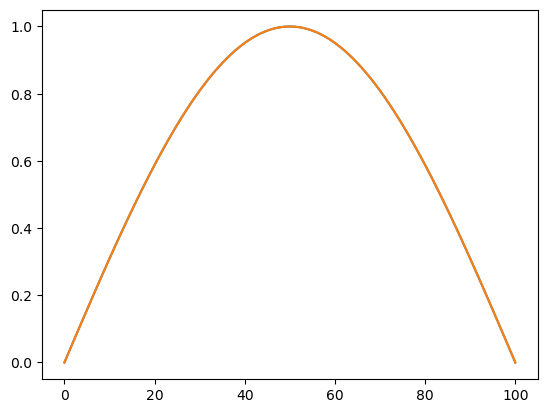

In [11]:
# problem data
omega = [0,np.pi]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)
N = 100 # number of subdivisions
n_qpoints = 1 # number of points for quadrature

# call function computing FEM system
A, F = FEM1_1D_GAUSS(omega, N, n_qpoints, rhs, mesh)
apply_boundary_conditions(omega, N, A, F, exact)

# solve
A = A.tocsr()
Uh = sp.linalg.spsolve(A, F)

# Evaluate exact solution at grid nodes
x = np.linspace(omega[0], omega[1], N + 1)
U = exact(x)

plt.plot(Uh)
plt.plot(U)

print(max(abs(U - Uh))) # compute discrete max norm error

Next we run few experiment to confirm the theoretical convergence and growth of the condition number.

In [12]:
# problem's data
omega = [0, 1]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

no_experiments = 8

Err = np.zeros(no_experiments)
NN = np.zeros(no_experiments)
Cond = np.zeros(no_experiments)

for i in range(no_experiments):

    N = 2**(i + 2)
    NN[i] = N
    n_qpoints = 1

    # call function computing FEM system
    A, F = FEM1_1D_GAUSS(omega, N, n_qpoints, rhs, mesh)
    apply_boundary_conditions(omega, N, A, F, exact)
    A_csr = A.tocsr()

    Uh = sp.linalg.spsolve(A_csr, F) # solve

    Cond[i] = np.linalg.cond(A_csr.todense(), p=2) # condition number of Stiffness matrix

    # evaluate exact solution at grid nodes
    vertices = mesh(omega, N)
    U = exact(vertices)
    
    Err[i] = max(abs(U - Uh)) # compute errors

print("NN:", NN)
print("Err:", Err)
print("Cond:", Cond)

NN: [  4.   8.  16.  32.  64. 128. 256. 512.]
Err: [1.53676799e-04 3.85799937e-05 9.76493285e-06 2.44060749e-06
 6.10152951e-07 1.52572678e-07 3.81430179e-08 9.53570156e-09]
Cond: [2.25520863e+01 6.89753098e+01 2.06780525e+02 6.45741996e+02
 2.15068415e+03 7.64827091e+03 2.85972709e+04 1.10330314e+05]


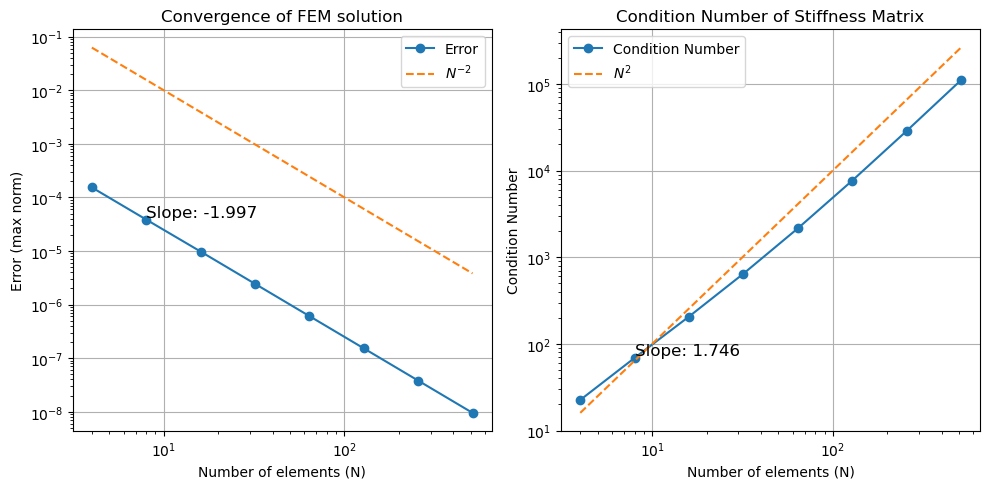

In [13]:
# Compute the slope of the error in log-log scale
log_NN = np.log(NN)
log_Err = np.log(Err)
log_Cond = np.log(Cond)
slope_err, _ = np.polyfit(log_NN, log_Err, 1)
slope_cond, _ = np.polyfit(log_NN, log_Cond, 1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the error in log-log scale
ax1.loglog(NN, Err, '-o', label='Error')
ax1.loglog(NN, NN**(-2), '--', label='$N^{-2}$')
ax1.text(NN[1], Err[1], f'Slope: {slope_err:.3f}', fontsize=12, verticalalignment='bottom')
ax1.set_xlabel('Number of elements (N)')
ax1.set_ylabel('Error (max norm)')
ax1.set_title('Convergence of FEM solution')
ax1.legend()
ax1.grid(True)

# Plot the condition number in log-log scale
ax2.loglog(NN, Cond, '-o', label='Condition Number')
ax2.loglog(NN, NN**2, '--', label='$N^2$')
ax2.text(NN[1], Cond[1], f'Slope: {slope_cond:.3f}', fontsize=12, verticalalignment='bottom')
ax2.set_xlabel('Number of elements (N)')
ax2.set_ylabel('Condition Number')
ax2.set_title('Condition Number of Stiffness Matrix')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**Exercise 1** Write a function computing $H^1$ norm error

The $H^1$ norm error measures the square root of the sum of the squared errors in both the solution $U_h$ and its gradient $\nabla U_h$ over the domain $\Omega$:
$$
\| u - U_h \|_{H^1(\Omega)} = \left( \| u - U_h \|_{L^2(\Omega)}^2 + \| \nabla u - \nabla U_h \|_{L^2(\Omega)}^2 \right)^{1/2} 
$$

where:

$\| u - U_h \|_{L^2(\Omega)}$ denotes the $L^2$ norm of the difference between the exact solution $u$ and the computed solution $U_h$:
$$ 
  \| u - U_h \|_{L^2(\Omega)} = \left( \int_\Omega (u(x) - U_h(x))^2 \, dx \right)^{1/2} 
$$

$\| \nabla u - \nabla U_h \|_{L^2(\Omega)}$ denotes the $L^2$ norm of the difference between the gradients of the exact solution $u$ and the computed solution $U_h$:
$$
  \| \nabla u - \nabla U_h \|_{L^2(\Omega)} = \left( \int_\Omega |\nabla u(x) - \nabla U_h(x)|^2 \, dx \right)^{1/2} 
$$


In [14]:
# Define a function to compute the L2 norm of the error
def L2_norm(omega, N, u, u_h, n_qpoints, mesh):
    vertices = mesh(omega, N)
    q, w = quadrature(n_qpoints)
    L2_norm_squared = 0
    
    for i in range(N):
        JxW = mapping_J(vertices, i) * w
        x = mapping(vertices, i)(q)
        
        # Error in function value
        e = u(x) - u_h[i] * basis1(0)(q) - u_h[i+1] * basis1(1)(q)
        L2_norm_squared += np.sum(e**2 * JxW)
    
    return np.sqrt(L2_norm_squared)

# Define a function to compute the H1 norm of the error
def H1_norm(omega, N, u, u_h, n_qpoints, mesh):
    vertices = mesh(omega, N)
    q, w = quadrature(n_qpoints)
    H1_norm_squared = 0.0
    
    for i in range(N):
        JxW = mapping_J(vertices, i) * w
        x = mapping(vertices, i)(q)
        
        # Error in function value
        e = u(x) - u_h[i] * basis1(0)(q) - u_h[i+1] * basis1(1)(q)
        H1_norm_squared += np.sum(e**2 * JxW)
        
        # Error in derivative value
        de = np.gradient(u(x), x) - (u_h[i+1] - u_h[i]) / mapping_J(vertices, i)
        H1_norm_squared += np.sum(de**2 * JxW)
    
    return np.sqrt(H1_norm_squared)

and test convergence this time for $\| u - u_h \|_{H^1(a,b)}$.

In [50]:
def apply_boundary_conditions_2(omega, N, A, F, g):
    A[0, :] = 0
    A[0, 0] = 1
    F[0]   = g(omega[0])

    A[N, :] = 0
    A[N, N] = 1
    F[N]   = g(omega[1])

In [51]:
def convergence(no_experiments, mesh, n_qpoints, omega, exact, rhs):

    Err = np.zeros(no_experiments)
    L2_Err = np.zeros(no_experiments)
    H1_Err = np.zeros(no_experiments)
    NN = np.zeros(no_experiments)
    Cond = np.zeros(no_experiments)

    for i in range(no_experiments):
        N = 2**(i + 2)
        NN[i] = N

        A, F = FEM1_1D_GAUSS(omega, N, n_qpoints, rhs, mesh)
        apply_boundary_conditions_2(omega, N, A, F, exact)
        A_csr = A.tocsr()

        Uh = sp.linalg.spsolve(A_csr, F)
        Cond[i] = np.linalg.cond(A_csr.todense(), p=2)

        vertices = mesh(omega, N)
        U = exact(vertices)

        Err[i] = max(abs(U - Uh))
        L2_Err[i] = L2_norm(omega, N, exact, Uh, n_qpoints, mesh)
        H1_Err[i] = H1_norm(omega, N, exact, Uh, n_qpoints, mesh)

    return NN, Err, L2_Err, H1_Err, Cond

In [52]:
def compute_slopes(NN, Err, L2_Err, H1_Err, Cond):
    slope_Err, _ = np.polyfit(np.log(NN), np.log(Err), 1)
    slope_L2, _ = np.polyfit(np.log(NN), np.log(L2_Err), 1)
    slope_H1, _ = np.polyfit(np.log(NN), np.log(H1_Err), 1)
    slope_Cond, _ = np.polyfit(np.log(NN), np.log(Cond), 1)

    return slope_Err, slope_L2, slope_H1, slope_Cond

In [53]:
# problem data
omega = [0, 1]
rhs = lambda x: np.sin(np.pi * x)
exact = lambda x: (1 / np.pi**2) * np.sin(np.pi * x)
exact_derivative = lambda x: (1 / np.pi) * np.cos(np.pi * x)

no_experiments = 8
n_qpoints = 5

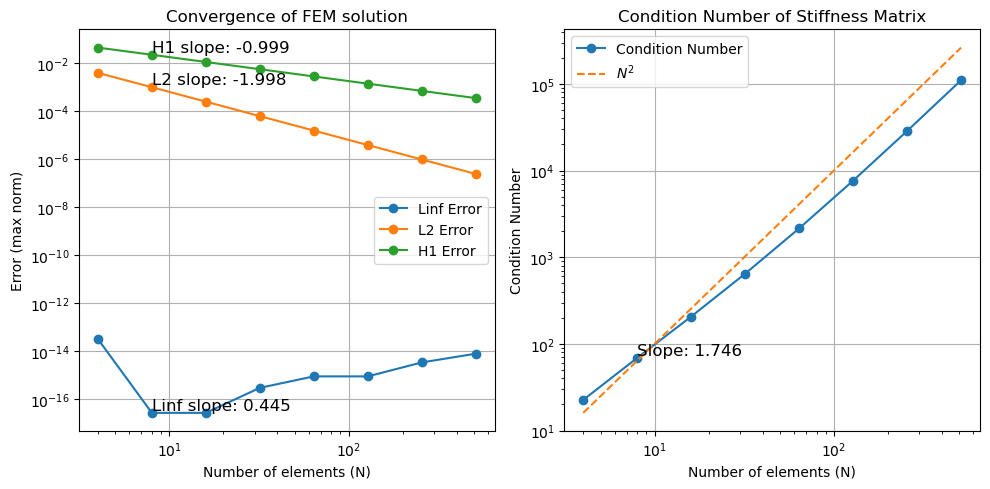

In [54]:
# experiment

NN, Err, L2_Err, H1_Err, Cond = convergence(no_experiments, mesh, n_qpoints, omega, exact, rhs)
slope_Err, slope_L2, slope_H1, slope_Cond = compute_slopes(NN, Err, L2_Err, H1_Err, Cond)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.loglog(NN, Err, '-o', label='Linf Error')
ax1.loglog(NN, L2_Err, '-o', label='L2 Error')
ax1.loglog(NN, H1_Err, '-o', label='H1 Error')
ax1.text(NN[1], Err[1], f'Linf slope: {slope_Err:.3f}', fontsize=12, verticalalignment='bottom')
ax1.text(NN[1], L2_Err[1], f'L2 slope: {slope_L2:.3f}', fontsize=12, verticalalignment='bottom')
ax1.text(NN[1], H1_Err[1], f'H1 slope: {slope_H1:.3f}', fontsize=12, verticalalignment='bottom')
ax1.set_xlabel('Number of elements (N)')
ax1.set_ylabel('Error (max norm)')
ax1.set_title('Convergence of FEM solution')
ax1.legend()
ax1.grid(True)

ax2.loglog(NN, Cond, '-o', label='Condition Number')
ax2.loglog(NN, NN**2, '--', label='$N^2$')
ax2.text(NN[1], Cond[1], f'Slope: {slope_Cond:.3f}', fontsize=12, verticalalignment='bottom')
ax2.set_xlabel('Number of elements (N)')
ax2.set_ylabel('Condition Number')
ax2.set_title('Condition Number of Stiffness Matrix')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**Exercise 2**: Try same exercise, this time with nonuniform grid

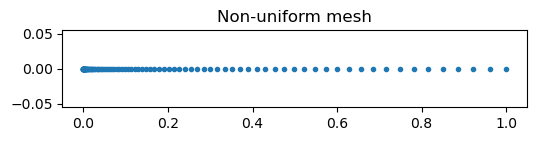

In [ ]:
# ridefine the mesh function to be used in FEM_1D_GAUSS
def non_uniform_mesh(omega, N, beta=4): # beta = 1 is uniform
    a, b = omega
    return np.linspace(a, b, N + 1)**beta

omega = [0, 1]
N = 100
vertices = non_uniform_mesh(omega, N)
plt.figure(figsize=(6, 1))
plt.plot(vertices, np.zeros_like(vertices), 'o', markersize=3)
plt.title('Non-uniform mesh')
plt.show()

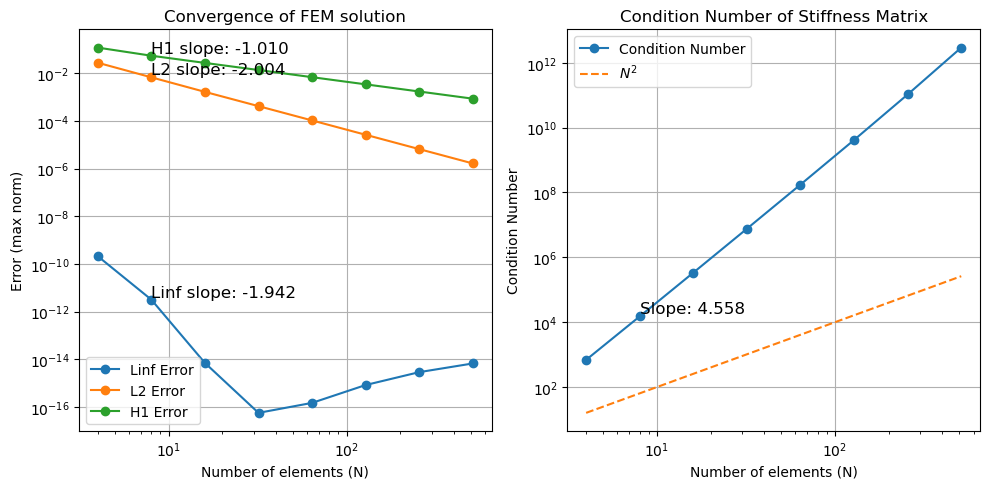

In [68]:
# Repeat the convergence study using a nonuniform grid, same problem data

NN, Err, L2_Err, H1_Err, Cond = convergence(no_experiments, non_uniform_mesh, n_qpoints, omega, exact, rhs)
slope_Err, slope_L2, slope_H1, slope_Cond = compute_slopes(NN, Err, L2_Err, H1_Err, Cond)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.loglog(NN, Err, '-o', label='Linf Error')
ax1.loglog(NN, L2_Err, '-o', label='L2 Error')
ax1.loglog(NN, H1_Err, '-o', label='H1 Error')
ax1.text(NN[1], Err[1], f'Linf slope: {slope_Err:.3f}', fontsize=12, verticalalignment='bottom')
ax1.text(NN[1], L2_Err[1], f'L2 slope: {slope_L2:.3f}', fontsize=12, verticalalignment='bottom')
ax1.text(NN[1], H1_Err[1], f'H1 slope: {slope_H1:.3f}', fontsize=12, verticalalignment='bottom')
ax1.set_xlabel('Number of elements (N)')
ax1.set_ylabel('Error (max norm)')
ax1.set_title('Convergence of FEM solution')
ax1.legend()
ax1.grid(True)

# Plot the condition number in log-log scale
ax2.loglog(NN, Cond, '-o', label='Condition Number')
ax2.loglog(NN, NN**2, '--', label='$N^2$')
ax2.text(NN[1], Cond[1], f'Slope: {slope_Cond:.3f}', fontsize=12, verticalalignment='bottom')
ax2.set_xlabel('Number of elements (N)')
ax2.set_ylabel('Condition Number')
ax2.set_title('Condition Number of Stiffness Matrix')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**Exercise 3**: Write code solving general reaction-advection-diffusion problems

In [63]:
def FEM1_1D_RAD(omega, N, n_qpoints, rhs, reaction_coef, advection_coef, diffusion_coef, mesh):
    
    vertices = mesh(omega, N) # grid

    q, w = quadrature(n_qpoints) # quadrature formula on reference element

    phi = np.array([basis1(i)(q) for i in range(2)]).T
    dphi = np.array([basis1_derivative(i)(q) for i in range(2)]).T

    A = sp.lil_matrix((N+1, N+1))
    F = np.zeros(N+1)

    for i in range(N):
        JxW = mapping_J(vertices, i) * w

        A_ele_diffusion = diffusion_coef * np.einsum('qi,qj,q', dphi, dphi, JxW) / mapping_J(vertices, i)**2
        A_ele_advection = advection_coef * np.einsum('qi,qj,q', phi, dphi, JxW) / mapping_J(vertices, i)
        A_ele_reaction = reaction_coef * np.einsum('qi,qj,q', phi, phi, JxW)
        
        A_ele = A_ele_diffusion + A_ele_advection + A_ele_reaction
        
        F_ele = np.einsum('qi,q,q', phi, rhs(mapping(vertices,i)(q)), JxW)

        A[i:i+2, i:i+2] += A_ele
        F[i:i+2] += F_ele

    return A, F

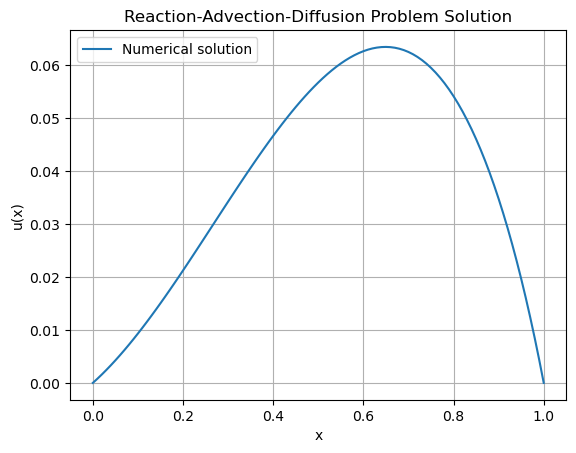

In [64]:
N = 100
n_qpoints = 5

diffusion_coef = 1.0
advection_coef = 5.0
reaction_coef = 3.0

A, F = FEM1_1D_RAD(omega, N, n_qpoints, rhs, reaction_coef, advection_coef, diffusion_coef, mesh)
apply_boundary_conditions(omega, N, A, F, exact)

A = A.tocsr()
Uh = sp.linalg.spsolve(A, F)

x = np.linspace(omega[0], omega[1], N + 1)
U = exact(x)

plt.plot(x, Uh, label='Numerical solution')
plt.legend()
plt.title('Reaction-Advection-Diffusion Problem Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid()
plt.show()

In [60]:
# Convergence study
# The exact solution is not known so we use the estimated order of convergence

omega = [0, 1]
rhs = lambda x: np.sin(np.pi * x)

diffusion_coef = 1.0
advection_coef = 2.0
reaction_coef = 3.0

theta = 0.5

n_qpoints = 5

uh_prev = None
err_prev = None
H1_err_prev = None

print("Estimated EOC")

for N in [2**i for i in range(2, 14)]:
    A, F = FEM1_1D_RAD(omega, N, n_qpoints, rhs, reaction_coef, advection_coef, diffusion_coef, mesh)
    apply_boundary_conditions(omega, N, A, F, exact)
    A = A.tocsr()
    Uh = sp.linalg.spsolve(A, F)

    if uh_prev is not None:
        err = max(abs(uh_prev - Uh[::2]))

        # the H1_norm function expects an exact solution but here we don't have it
        # we can solve this issue by interpolating the previous numerical solution
        h1_err = H1_norm(omega, N, lambda x: np.interp(x, mesh(omega, len(uh_prev)-1), uh_prev), Uh, 2, mesh)

        if err_prev is not None:
            k = np.log(err / err_prev) / np.log(theta)

        if H1_err_prev is not None:
            k_H1 = np.log(h1_err / H1_err_prev) / np.log(theta)
            print(f'N = {N}: L-infinity norm: {np.around(k, 3)}; H1 norm: {np.around(k_H1, 3)}')

        err_prev = err
        H1_err_prev = h1_err

    uh_prev = Uh

Estimated EOC
N = 16: L-infinity norm: 2.012; H1 norm: 1.002
N = 32: L-infinity norm: 2.003; H1 norm: 1.001
N = 64: L-infinity norm: 2.001; H1 norm: 1.0
N = 128: L-infinity norm: 2.0; H1 norm: 1.0
N = 256: L-infinity norm: 2.0; H1 norm: 1.0
N = 512: L-infinity norm: 2.0; H1 norm: 1.0
N = 1024: L-infinity norm: 2.0; H1 norm: 1.0
N = 2048: L-infinity norm: 2.0; H1 norm: 1.0
N = 4096: L-infinity norm: 2.0; H1 norm: 1.0
N = 8192: L-infinity norm: 1.999; H1 norm: 1.0
